In [1]:
# !pip uninstall tensorflow
# !pip install tensorflow_hub
# !pip install tensorflow_text

In [2]:
# pip install tensorflow==2.15.*
# !pip install -U "tensorflow-text==2.15.*"
# !pip install -U "tf-models-official==2.15.*"

In [1]:
import tensorflow_hub as hub
import tensorflow_text as text
import tensorflow as tf

import pandas as pd
import nltk
import numpy as np
from sklearn.model_selection import train_test_split
from nltk.tokenize import word_tokenize, sent_tokenize
import string, re, nltk
from nltk.corpus import stopwords
nltk.download('punkt')
nltk.download('stopwords')

import warnings
warnings.filterwarnings('ignore')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [2]:
preprocessor = hub.KerasLayer("https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3", name="preprocessing")
encoder = hub.KerasLayer("https://tfhub.dev/tensorflow/bert_en_uncased_L-12_H-768_A-12/4", name="BERT_encoder")

**Example Usage - BERT Processor and Encoder**

In [3]:
text_test = ['nice movie indeed', 'I hate it sometimes though!!']
preprocessed_text = preprocessor(text_test)
print(preprocessed_text.keys())

output = encoder(preprocessed_text)
output.keys()

dict_keys(['input_type_ids', 'input_mask', 'input_word_ids'])


dict_keys(['sequence_output', 'encoder_outputs', 'default', 'pooled_output'])

In [4]:
output['pooled_output']

<tf.Tensor: shape=(2, 768), dtype=float32, numpy=
array([[-0.791774  , -0.21411912,  0.49769545, ...,  0.24465235,
        -0.47334474,  0.8175869 ],
       [-0.7811995 , -0.40898427, -0.48670244, ..., -0.21824645,
        -0.62682813,  0.8872608 ]], dtype=float32)>

**Reading the Saved CSV**

In [5]:
df = pd.read_csv('/content/drive/MyDrive/mentalhealth_comments.csv')

In [6]:
df = df[['comment_id', 'comment_body']]
df.sample(10)

,comment_id,comment_body
505,kf6le75,I love a ribeye!\n\nThe rest of your comment h...
2660,kf7l28c,"Sadly most of the advice, while useful, is FAR..."
507,kf61etp,I bet most people deal with it just like you h...
2317,kf68p0f,"First two are good to begin with, third is too..."
119,kf8g54s,I wrote a journal bashing my ex. It was liberting
2820,kf62wry,I feel you. Living a healthy lifestyle can fee...
2180,kf6vdkr,Butterfly Effect guy
1821,kf6kjwy,Journals and diaries are great for when you ne...
238,kf6jot3,Yeh good advise. It’s too steep. For me I’ll t...
1255,kf6db85,Really not that hard or difficult


In [7]:
train_df = df.iloc[:2000, :]
test_df = df.iloc[train_df.shape[0]: , :]

In [8]:
train_df.shape, test_df.shape, len(train_df + test_df)

((2000, 2), (995, 2), 2995)

**First I've defined sentiments for each thread using SentimentVader**

In [9]:
def preprocess_text(text):
    words = word_tokenize(text)
    stop_words = set(stopwords.words('english'))
    filtered_words = [word for word in words if word not in stop_words]
    text = ' '.join(filtered_words)
    return text

train_df['cleaned_comment_text'] = train_df['comment_body'].apply(preprocess_text)
test_df['cleaned_comment_text'] = test_df['comment_body'].apply(preprocess_text)

In [10]:
from nltk.sentiment.vader import SentimentIntensityAnalyzer

nltk.download('vader_lexicon')

vader_analyzer = SentimentIntensityAnalyzer()

def sentiment_analyzer(text):
    scores = vader_analyzer.polarity_scores(text)
    compound_score = scores['compound']
    return 'positive' if compound_score >= 0 else 'negative'

[nltk_data] Downloading package vader_lexicon to /root/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


In [11]:
train_df['sentiment'] = train_df['cleaned_comment_text'].apply(sentiment_analyzer)
test_df['sentiment'] = test_df['cleaned_comment_text'].apply(sentiment_analyzer)

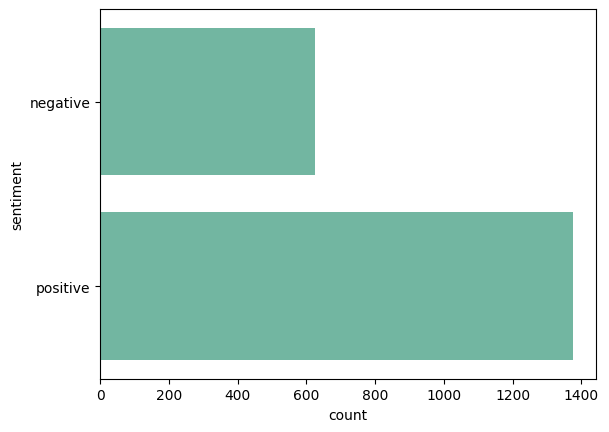

In [12]:
import seaborn as sns
import matplotlib.pyplot as plt
sns.set_palette('Set2')
sns.countplot(train_df['sentiment'])
plt.show()

**To address class imbalance -> Class Weight Method**

In [13]:
train_df['label'] = train_df['sentiment'].map({'positive': 1, 'negative': 0})
test_df['label'] = test_df['sentiment'].map({'positive': 1, 'negative': 0})


X_train, X_val, y_train, y_val = train_test_split(
    train_df['comment_body'], train_df['label'], test_size = 0.1, random_state = 43, stratify = train_df['label']
)

In [15]:
from sklearn.utils.class_weight import compute_class_weight
import numpy as np

class_weight = compute_class_weight(
    class_weight = 'balanced',
    classes = np.unique(y_train),
    y = y_train
)

In [17]:
class_weight_dict = dict(enumerate(class_weight))
class_weight_dict

{0: 1.5985790408525755, 1: 0.7275666936135813}

**Bert Model**

In [18]:
# Bert Layers
text_input = tf.keras.layers.Input(shape=(), dtype=tf.string, name='text')
preprocessed_text = preprocessor(text_input)
encoded_text = encoder(preprocessed_text)['pooled_output']

# NN Layers
# Regularization
l = tf.keras.layers.Dropout(0.1, name = 'DropOut')(encoded_text)
# Fully Connected
l = tf.keras.layers.Dense(1, activation = 'sigmoid' ,name = 'Dense')(l)

model = tf.keras.Model(inputs = [text_input], outputs = [l])

In [19]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 text (InputLayer)           [(None,)]                    0         []                            
                                                                                                  
 preprocessing (KerasLayer)  {'input_type_ids': (None,    0         ['text[0][0]']                
                             128),                                                                
                              'input_mask': (None, 128)                                           
                             , 'input_word_ids': (None,                                           
                              128)}                                                               
                                                                                              

In [20]:
METRICS = [
    tf.keras.metrics.BinaryAccuracy(name='accuracy'),
    tf.keras.metrics.Precision(name='precision'),
    tf.keras.metrics.Recall(name='recall')
]

model.compile(
    optimizer = 'adam',
    loss = 'binary_crossentropy',
    metrics = METRICS
)

In [21]:
model.fit(X_train, y_train, epochs=10, batch_size=32, class_weight=class_weight_dict)

Epoch 1/10
57/57 [==============================] - 31s 353ms/step - loss: 0.7140 - accuracy: 0.5189 - precision: 0.6988 - recall: 0.5271
Epoch 2/10
57/57 [==============================] - 20s 346ms/step - loss: 0.6871 - accuracy: 0.5300 - precision: 0.7347 - recall: 0.4947
Epoch 3/10
57/57 [==============================] - 19s 329ms/step - loss: 0.6602 - accuracy: 0.6117 - precision: 0.7701 - recall: 0.6200
Epoch 4/10
57/57 [==============================] - 19s 337ms/step - loss: 0.6621 - accuracy: 0.5811 - precision: 0.7616 - recall: 0.5683
Epoch 5/10
57/57 [==============================] - 20s 343ms/step - loss: 0.6448 - accuracy: 0.6128 - precision: 0.7789 - recall: 0.6095
Epoch 6/10
57/57 [==============================] - 20s 346ms/step - loss: 0.6285 - accuracy: 0.6311 - precision: 0.8032 - recall: 0.6136
Epoch 7/10
57/57 [==============================] - 19s 337ms/step - loss: 0.6288 - accuracy: 0.6400 - precision: 0.8052 - recall: 0.6281
Epoch 8/10
57/57 [================

In [23]:
loss = model.evaluate(X_val, y_val)
print(f'Accuracy : {loss[0]}')
print(f'Precision : {loss[1]}')
print(f'Recall : {loss[2]}')
print(f'f1 : {loss[3]}')

7/7 [==============================] - 2s 310ms/step - loss: 0.6175 - accuracy: 0.6750 - precision: 0.9091 - recall: 0.5839
Accuracy : 0.6174843311309814
Precision : 0.675000011920929
Recall : 0.9090909361839294
f1 : 0.5839415788650513


In [24]:
y_pred = model.predict(X_val)
y_pred = y_pred.flatten()
y_pred = np.where(y_pred > 0.5, 1, 0)
y_pred

7/7 [==============================] - 3s 332ms/step


array([1, 1, 1, 0, 0, 1, 0, 0, 0, 1, 0, 1, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0,
       0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 0, 1, 1, 1, 0, 0, 1, 1, 1, 0, 0,
       0, 0, 1, 1, 0, 1, 0, 0, 1, 1, 0, 1, 1, 0, 0, 0, 0, 1, 1, 0, 1, 1,
       0, 0, 0, 0, 1, 0, 1, 1, 1, 0, 1, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 1,
       1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0,
       0, 1, 0, 1, 0, 0, 0, 0, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1,
       0, 0, 0, 1, 1, 1, 1, 0, 1, 0, 0, 1, 1, 0, 0, 0, 1, 1, 0, 0, 1, 0,
       1, 0, 1, 0, 0, 0, 1, 0, 1, 1, 1, 1, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0,
       0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 1, 1, 1,
       0, 0])

Text(50.722222222222214, 0.5, 'Truth')

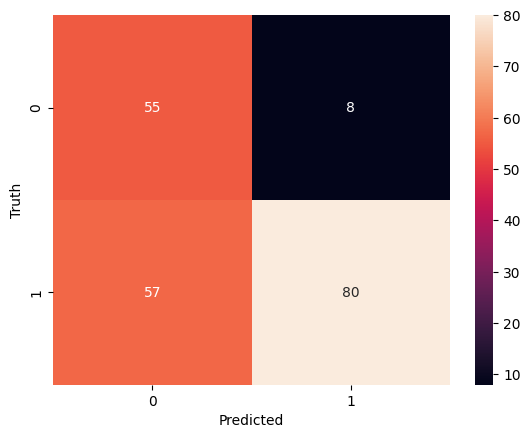

In [25]:
from sklearn.metrics import confusion_matrix, classification_report

cm = confusion_matrix(y_val, y_pred)

sns.heatmap(cm, annot=True, fmt='d')
plt.xlabel('Predicted')
plt.ylabel('Truth')

In [26]:
print(classification_report(y_val, y_pred))

              precision    recall  f1-score   support

           0       0.49      0.87      0.63        63
           1       0.91      0.58      0.71       137

    accuracy                           0.68       200
   macro avg       0.70      0.73      0.67       200
weighted avg       0.78      0.68      0.69       200



In [27]:
y_test_pred = model.predict(test_df['comment_body'])
y_test_pred = np.where(y_test_pred > 0.5 , "Positive", "Negative").flatten()
y_test_pred

32/32 [==============================] - 11s 338ms/step


array(['Positive', 'Positive', 'Negative', 'Positive', 'Positive',
       'Positive', 'Positive', 'Negative', 'Positive', 'Positive',
       'Positive', 'Negative', 'Negative', 'Negative', 'Negative',
       'Positive', 'Negative', 'Positive', 'Negative', 'Negative',
       'Negative', 'Negative', 'Positive', 'Negative', 'Positive',
       'Positive', 'Negative', 'Positive', 'Positive', 'Negative',
       'Negative', 'Negative', 'Negative', 'Positive', 'Negative',
       'Positive', 'Negative', 'Negative', 'Positive', 'Negative',
       'Negative', 'Positive', 'Negative', 'Negative', 'Negative',
       'Negative', 'Negative', 'Negative', 'Negative', 'Positive',
       'Negative', 'Positive', 'Negative', 'Positive', 'Negative',
       'Positive', 'Negative', 'Positive', 'Negative', 'Negative',
       'Positive', 'Positive', 'Negative', 'Negative', 'Negative',
       'Negative', 'Negative', 'Negative', 'Negative', 'Negative',
       'Positive', 'Positive', 'Negative', 'Negative', 'Positi

In [28]:
sub_threads = [
    "I feel empty, nothing makes me happy",
    "Anyone else just soo exhausted from life?",
    "What's something that recently made you happy?",
    "Share your best 'feel-good' story"
]

sub_threads_pred = model.predict(sub_threads)

1/1 [==============================] - 1s 776ms/step


In [29]:
result = np.where(sub_threads_pred > 0.5 , "Positive", "Negative").flatten()
result

array(['Negative', 'Positive', 'Negative', 'Positive'], dtype='<U8')